# 

<table style="background-color: transparent;">
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%" align="center"><font size="7" color="#f25625">Análisis y Procesamiento Inteligente de Textos</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="grey">Elias Eduardo Gonzáles Sotelo<br>
        Bryan Jesús Gonzáles Villalba<br>
        Rodrigo Gael Guzmán Alburo<br>
        Luis Eduardo Ríos Nava<br>
        Alexis Isaías Rodríguez Ortiz<br>
        </font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="4" color="grey">Grupo:01<br>2025-2</font></td>
    </tr>
    <tr style="background-color: transparent; text-align:center;">
        <td width="100%"><font size="6" color="#f25625">Proyecto Final: Clasificador de Noticias Falsas en Español</font></td>
    </tr>
</table>

## Contenido

1. [Importación de Librerias](#1)
2. [Carga los *datasets*](#2)
3. [Limpieza de Texto](#3)
4. [Tokenización y Vectorización](#4)
5. [Comparación de Modelos Traficionales](#5)
6. [Probando el Modelo Naive Bayes](#6)
7. [Implementación con el modelo SaBERT](#7)
8. [Probando el modelo SaBERT](#8)
9. [Comparación detallada de modelos](#9)
   1. [Matrices de confusión](#9.1)
   2. [Análisis de métricas](#9.2)
10. [Predicción de noticias no supervisadas con ambos modelos](#10)

## Introducción

En este notebook se compararan tres modelos de clasificación tradicionales entre sí, y de estos, se seleccionará el mejor para compararlo con un modelo de *Deep Learning* llamado SaBERT. El objetivo es evaluar cuál de los modelos es más efectivo para clasificar noticias en categorías específicas: "Noticias Verdaderas" y "Noticias Falsas".

## Descripción de los datasets

Para este proyecto se utilizarán tres datasets obtenidos de Kaggle:
- `onlyfakes1000.csv`: Contiene 1000 noticias falsas.
- `onlytrue1000.csv`: Contiene 1000 noticias verdaderas.
- `test.csv`: Contiene 400 noticias sin clasificar, se utilizará para probar los modelos.

Los tres datasets se obtuvieron del siguiente enlace: [noticias falsas en español](https://www.kaggle.com/datasets/arseniitretiakov/noticias-falsas-en-espaol?resource=download&select=test.csv).

<a id="1"></a>
## 1. Importación de Librerias

In [2]:
import pandas as pd # Manejo de datos

import torch # Para compatibilidad con modelo SaBERT

from nltk.corpus import stopwords # Limpieza de datos

# Tokenización
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split # División de datos

# Modelos
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import LogisticRegression # Regresión Logística

from transformers import BertForSequenceClassification, BertTokenizer # Modelo SaBERT y tokenizador

# Evaluación
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm # Barra de progreso

Instalación de las librerías:

```bash
pip install pandas torch nltk scikit-learn transformers matplotlib seaborn tqdm ipykernel
```

<a id="2"></a>
## 2. Carga los *datasets*

Se cargan dos *datasets* distintos, uno solamente con noticias verdaderas y otro con noticias falsas, cada uno con 1000 registros cada uno. Se cargan en dos variables distintas, `true_dataset` y `fake_dataset`, respectivamente. Adicionalmente, en ambos *datasets* se agrega una nueva columna llamada `class`, que contiene el valor 1 para las noticias verdaderas y 0 para las noticias falsas.

In [3]:
true_dataset = pd.read_csv("data/onlytrue1000.csv")
true_dataset["class"] = 1
print(true_dataset)

                                                  text  class
0     Algunas de las voces extremistas más conocida...      1
1     Después de casi dos años y medio de luchas po...      1
2     Dos periodistas birmanos de la agencia Reuter...      1
3     El Cuerpo Nacional de Policía ha detenido a c...      1
4     El desfile de la firma en Roma se convierte e...      1
..                                                 ...    ...
995   El Consejo de Gobierno ha dado su visto bueno...      1
996   Investigadores valencianos han desarrollado u...      1
997   Los arrestados actuaban en coches y en establ...      1
998   El Rey ha encargado este miércoles a Pedro Sá...      1
999   Las pruebas realizadas en el Centro Nacional ...      1

[1000 rows x 2 columns]


In [4]:
false_dataset = pd.read_csv("data/onlyfakes1000.csv")
false_dataset["class"] = 0
print(false_dataset)

                                                  text  class
0     El suceso ha tenido lugar en Brasil. Un adole...      0
1     Estamos en la semana decisiva. Los expertos a...      0
2     Estudios científicos hay muchos. Unos nos int...      0
3     Ha sucedido en la ciudad de San José de Río P...      0
4     La fiesta en Sevilla por el vuelco electoral ...      0
..                                                 ...    ...
995  Reenviado... Me acaban de llegar a casa por co...      0
996  JULIO ANGUITA: "El que debería estar en la cár...      0
997  Otegi reclama la salida de prisión de todos lo...      0
998  Otegi reclama la salida de prisión de todos lo...      0
999  ¡ALERTA! ¡Estos paquetes de merienda son pelig...      0

[1000 rows x 2 columns]


Se mezclan los dos *datasets* en un solo *dataset* llamado `df`:

In [5]:
df = pd.concat([true_dataset, false_dataset], axis = 0).reset_index(drop=True)
df

,text,class
0,Algunas de las voces extremistas más conocida...,1
1,Después de casi dos años y medio de luchas po...,1
2,Dos periodistas birmanos de la agencia Reuter...,1
3,El Cuerpo Nacional de Policía ha detenido a c...,1
4,El desfile de la firma en Roma se convierte e...,1
...,...,...
1995,Reenviado... Me acaban de llegar a casa por co...,0
1996,"JULIO ANGUITA: ""El que debería estar en la cár...",0
1997,Otegi reclama la salida de prisión de todos lo...,0
1998,Otegi reclama la salida de prisión de todos lo...,0


<a id="3"></a>
## 3. Limpieza de Texto

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   class   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Observamos que "class" es de tipo entero, pero queremos que sea un dato categórico. A continuación se modifica el tipo de dato:

In [7]:
df.astype({"class": "category"}).dtypes

text       object
class    category
dtype: object

Una vez tenemos bien catalogados los tipos de datos, ahora removeremos de las noticias todas las *stopwords*. Las *stopwords* son palabras que no aportan información relevante al texto, como "el", "la", "y", etc. Para ello, se utiliza la librería `nltk` y su lista de *stopwords* en español. Se eliminan las *stopwords* de cada noticia y se almacenan en una nueva columna llamada `clean_text`.

In [8]:
stop_words = list(stopwords.words("spanish"))

# Añade algunas palabras que no están en el listado de NLTK
stop_words.extend(['según','tras','cabe','bajo', 'durante', 'mediante', 'so','toda','todas',
                   'cada','me','después','despues','segun','solo','sido','estan','lunes',
                   'martes','miércoles','jueves','viernes'])
print("Stop words:", stop_words)

Stop words: ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis',

In [9]:
# Función para eliminar stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [10]:
# Aplica la función a la columna 'text'
df["clean_text"] = df["text"].apply(remove_stop_words)

In [11]:
# Texto antes de eliminar stop words
print(df["text"][5])

 El miedo a la pérdida de identidad y la aversión a los inmigrantes ha sido el combustible que ha hecho crecer a la extrema derecha en toda Europa. Sus líderes quieren convertirla en una fortaleza inexpugnable frente a quienes ahora la asedian con frágil


In [12]:
# Texto después de eliminar stop words
print(df["clean_text"][5])

El miedo pérdida identidad aversión inmigrantes combustible hecho crecer extrema derecha Europa. Sus líderes quieren convertirla fortaleza inexpugnable frente ahora asedian frágil


In [13]:
df

,text,class,clean_text
0,Algunas de las voces extremistas más conocida...,1,"Algunas voces extremistas conocidas EE.UU., cu..."
1,Después de casi dos años y medio de luchas po...,1,Después casi dos años medio luchas políticas j...
2,Dos periodistas birmanos de la agencia Reuter...,1,Dos periodistas birmanos agencia Reuters liber...
3,El Cuerpo Nacional de Policía ha detenido a c...,1,El Cuerpo Nacional Policía detenido cuatro per...
4,El desfile de la firma en Roma se convierte e...,1,El desfile firma Roma convierte oda libertad m...
...,...,...,...
1995,Reenviado... Me acaban de llegar a casa por co...,0,Reenviado... Me acaban llegar casa correo pape...
1996,"JULIO ANGUITA: ""El que debería estar en la cár...",0,"JULIO ANGUITA: ""El debería cárcel Jordi Pujol,..."
1997,Otegi reclama la salida de prisión de todos lo...,0,Otegi reclama salida prisión etarras apoyar in...
1998,Otegi reclama la salida de prisión de todos lo...,0,Otegi reclama salida prisión etarras apoyar in...


<a id="4"></a>
## 4. Tokenización y Vectorización

Primero dividimos el *dataset* en dos partes, una para entrenamiento y otra para prueba. La parte de entrenamiento contiene el 80% de los datos y la parte de prueba contiene el 20% restante.

In [14]:
X= df["clean_text"]
y= df["class"]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 1600
Tamaño del conjunto de prueba: 400


Tokenizamos los datos para dividir las noticias en palabras individuales. Después, se utiliza la técnica de *vectorización* para convertir las palabras en números. Para ello, se utiliza el `CountVectorizer` de `sklearn`, que convierte cada palabra en un número entero único.

Esto crea una matriz de números enteros, donde cada fila representa una noticia y cada columna representa una palabra del vocabulario. Los valores de la matriz son la cantidad de veces que aparece cada palabra en cada noticia.

In [15]:
vect = CountVectorizer()
X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)
print("Tamaño del conjunto de entrenamiento vectorizado:", X_train_vectorized.shape)
print("Tamaño del conjunto de prueba vectorizado:", X_test_vectorized.shape)

Tamaño del conjunto de entrenamiento vectorizado: (1600, 11608)
Tamaño del conjunto de prueba vectorizado: (400, 11608)


<a id="5"></a>
## 5. Comparación de Modelos Tradicionales

En este proyecto se compararan tres modelos tradicionales distintos:

1. Random Forest
2. Naive Bayes
3. Logistic Regression

#### 1. Random Forest

In [16]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vectorized, y_train)

# Predicciones
y_pred = rf_model.predict(X_test_vectorized)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud de Random Forest: %.2f%%" % (accuracy*100.0))

Exactitud de Random Forest: 71.25%


#### 2. Naive Bayes

In [17]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# Predicciones
y_pred_nb = nb_model.predict(X_test_vectorized)

# Evaluación del modelo
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Exactitud de Naive Bayes: %.2f%%" % (accuracy_nb*100.0))

Exactitud de Naive Bayes: 76.75%


#### 3. Logistic Regression

In [18]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_vectorized, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_vectorized)

# Evaluación del modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Exactitud de Logistic Regression: %.2f%%" % (accuracy_lr*100.0))

Exactitud de Logistic Regression: 74.25%


Para comparar la exactitud de los modelos, se presenta una gráfica que muestra la precisión de cada modelo en el conjunto de prueba.

C:\Users\PC\AppData\Local\Temp\ipykernel_22616\3853990229.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modelos, y=exactitudes, palette='Set2')


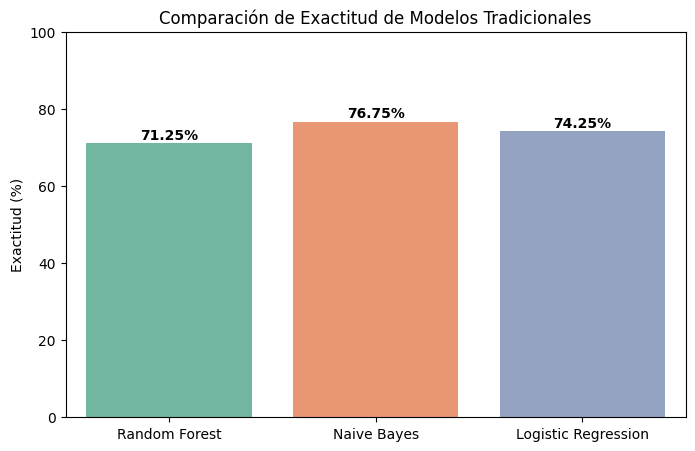

In [19]:
# Gráfica de comparación de exactitudes de los modelos tradicionales
modelos = ['Random Forest', 'Naive Bayes', 'Logistic Regression']
exactitudes = [accuracy*100, accuracy_nb*100, accuracy_lr*100]

plt.figure(figsize=(8,5))
sns.barplot(x=modelos, y=exactitudes, palette='Set2')
plt.ylabel('Exactitud (%)')
plt.ylim(0, 100)
plt.title('Comparación de Exactitud de Modelos Tradicionales')
for i, v in enumerate(exactitudes):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

El modelo con mayor exactitud resultó ser Naive Bayes con un $76.76\%$. Este será nuestro modelo final.

<a id="6"></a>
## 6. Probando el Modelo Naive Bayes

Tenemos el siguiente *dataset* de prueba:

In [85]:
test_df = pd.read_csv("data/test.csv")
test_df

,title,text
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó..."
2,Valencia multará los balcones con banderas por...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...
3,Un directivo de Hazte Oír se besa con una muje...,"Suecia está haciendo un experimento, ha reduci..."
4,Iglesias y Montero se compran también un apart...,Suecia sigue avanzando hacia su islamización. ...
...,...,...
395,"Aumenta un 88,7% el número de autónomos mayore...",El Consejo de Gobierno ha dado su visto bueno...
396,Asesinan a un periodista involucrado en la luc...,Investigadores valencianos han desarrollado u...
397,La fértil cosecha de Porfirio Fisac en el Zara...,Los arrestados actuaban en coches y en establ...
398,Antonio Banderas: Mi novia me salvó la vida co...,El Rey ha encargado este miércoles a Pedro Sá...


Eliminamos los registros faltantes y aplicamos la función de limpieza de texto.

In [86]:
test_df.dropna(subset=["text"], inplace=True)
test_df["clean_text"] = test_df["text"].apply(remove_stop_words)
test_df

,title,text,clean_text
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...,Spanish nationalism rabid that Catalan company...
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó...","Su amante, llamó marido llorando contó pasando..."
2,Valencia multará los balcones con banderas por...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...
3,Un directivo de Hazte Oír se besa con una muje...,"Suecia está haciendo un experimento, ha reduci...","Suecia haciendo experimento, reducido jornada ..."
4,Iglesias y Montero se compran también un apart...,Suecia sigue avanzando hacia su islamización. ...,Suecia sigue avanzando hacia islamización. Seg...
...,...,...,...
395,"Aumenta un 88,7% el número de autónomos mayore...",El Consejo de Gobierno ha dado su visto bueno...,El Consejo Gobierno dado visto bueno convocato...
396,Asesinan a un periodista involucrado en la luc...,Investigadores valencianos han desarrollado u...,Investigadores valencianos desarrollado innova...
397,La fértil cosecha de Porfirio Fisac en el Zara...,Los arrestados actuaban en coches y en establ...,Los arrestados actuaban coches establecimiento...
398,Antonio Banderas: Mi novia me salvó la vida co...,El Rey ha encargado este miércoles a Pedro Sá...,El Rey encargado Pedro Sánchez presente invest...


A continuación se convierte el texto a una matriz de conteo de tokens:

In [87]:
test_dtm = vect.transform(test_df["clean_text"])

Ahora realizamos la predicción:

In [89]:
y_pred_test = nb_model.predict(test_dtm)
test_df["predicted_class"] = pd.Series(y_pred_test).map({1: "True", 0: "Fake"})
test_df["predicted_class"].value_counts()

predicted_class
True    202
Fake    198
Name: count, dtype: int64

En total tenemos se predicen:
- 202 noticias verdaderas.
- 198 noticias falsas.

Observamos las primeras 5 noticias predichas como verdaderas:

In [90]:
test_df[test_df["predicted_class"] == "True"].head(5)

,title,text,clean_text,predicted_class
18,NaN,Tremendo vídeo el que ha publicado 'Il Giornal...,Tremendo vídeo publicado 'Il Giornale'. En pue...,True
47,NaN,Un informe elaborado por una de las oficinas d...,Un informe elaborado oficinas Parlamento Europ...,True
100,Entra en prisión el joven condenado a 6 años p...,La cuenta atrás terminó diez minutos antes de ...,La cuenta atrás terminó diez minutos siete tar...,True
111,NaN,Esta tarde un agente del indicativo Puma 70 de...,Esta tarde agente indicativo Puma 70 Unidad In...,True
122,NaN,Última hora | Un edificio arde presa de las ll...,Última hora | Un edificio arde presa llamas. L...,True


Y las primeras 5 noticias predichas como falsas:

In [91]:
test_df[test_df["predicted_class"] == "Fake"].head(5)

,title,text,clean_text,predicted_class
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...,Spanish nationalism rabid that Catalan company...,Fake
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó...","Su amante, llamó marido llorando contó pasando...",Fake
2,Valencia multará los balcones con banderas por...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...,Fake
3,Un directivo de Hazte Oír se besa con una muje...,"Suecia está haciendo un experimento, ha reduci...","Suecia haciendo experimento, reducido jornada ...",Fake
4,Iglesias y Montero se compran también un apart...,Suecia sigue avanzando hacia su islamización. ...,Suecia sigue avanzando hacia islamización. Seg...,Fake


<a id="7"></a>
## 7. Implementación con el modelo SaBERT

Cargamos el modelo pre-entrenado de SaBERT de Hugging Face, el cual fue entrenado con un *dataset* de 125,000 noticias falsas y verdaderas en español.

In [ ]:
model = BertForSequenceClassification.from_pretrained("VerificadoProfesional/SaBERT-Spanish-Fake-News")
tokenizer = BertTokenizer.from_pretrained("VerificadoProfesional/SaBERT-Spanish-Fake-News")

Función de predicción para el modelo SaBERT:

In [121]:
# Función para hacer predicciones en lote
def predict_batch(model, tokenizer, texts, threshold=0.5, batch_size=16):
    predictions = []
    probabilities_list = []
    
    # Procesar en lotes para ser más eficiente
    for i in tqdm(range(0, len(texts), batch_size), desc="Prediciendo con SaBERT"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenizar el lote
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, 
                          truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_classes = torch.argmax(logits, dim=1)
        
        # Aplicar threshold y mapear predicciones
        for j, pred_class in enumerate(predicted_classes):
            prob = probabilities[j].tolist()
            
            # Aplicar threshold
            if prob[pred_class.item()] <= threshold and pred_class.item() == 1:
                pred_class = 0
            
            
            predictions.append(pred_class.item())
            probabilities_list.append(prob)
    
    return predictions, probabilities_list

A continuación se prueba el modelo con el *dataset* de entrenamiento utilizado anteriormente con los modelos tradicionales.

In [103]:
y_pred_bert, bert_probabilities = predict_batch(model, tokenizer, X_test.tolist())

Prediciendo con BERT: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


In [151]:
# Calcula métricas de evaluación
accuracy_bert = accuracy_score(y_test, y_pred_bert)
print("Accuracy BERT: %.2f%%" % (accuracy_bert*100.0))

Accuracy BERT: 55.00%


La exactitud del modelo SaBERT resultante fue del $55\%$, lo que indica un desempeño deficiente, especialmente en comparación con el modelo Naive Bayes, que tuvo una exactitud del $76.76\%$. Esto sugiere que el modelo SaBERT no es adecuado para la tarea de clasificación de noticias en este caso particular.

<a id="8"></a>
## 8. Probando el Modelo SaBERT

Evaluamos el modelo SaBERT con el mismo *dataset* de prueba usado en el modelo Naive Bayes en el punto 6.

In [119]:
# Caramos el dataset de prueba y lo guardamos con un nombre diferente
test_df_bert = pd.read_csv("data/test.csv")
# Eliminamos los registros que no tienen texto
test_df_bert.dropna(subset=["text"], inplace=True)

# Aplicamos la función de limpieza de texto
test_df_bert["clean_text"] = test_df_bert["text"].apply(remove_stop_words)

test_df_bert

,title,text,clean_text
0,Podemos estudia en su programa playas para muj...,Spanish nationalism rabid that a Catalan compa...,Spanish nationalism rabid that Catalan company...
1,Alemania va a quitar los hijos a los padres po...,"Su amante, llamó al marido llorando y le contó...","Su amante, llamó marido llorando contó pasando..."
2,Valencia multará los balcones con banderas por...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...,SUBEN LAS PENSIONES 1 EURO Y SUBEN EL RECIBO D...
3,Un directivo de Hazte Oír se besa con una muje...,"Suecia está haciendo un experimento, ha reduci...","Suecia haciendo experimento, reducido jornada ..."
4,Iglesias y Montero se compran también un apart...,Suecia sigue avanzando hacia su islamización. ...,Suecia sigue avanzando hacia islamización. Seg...
...,...,...,...
395,"Aumenta un 88,7% el número de autónomos mayore...",El Consejo de Gobierno ha dado su visto bueno...,El Consejo Gobierno dado visto bueno convocato...
396,Asesinan a un periodista involucrado en la luc...,Investigadores valencianos han desarrollado u...,Investigadores valencianos desarrollado innova...
397,La fértil cosecha de Porfirio Fisac en el Zara...,Los arrestados actuaban en coches y en establ...,Los arrestados actuaban coches establecimiento...
398,Antonio Banderas: Mi novia me salvó la vida co...,El Rey ha encargado este miércoles a Pedro Sá...,El Rey encargado Pedro Sánchez presente invest...


Ahora realizamos la predicción usando la función que creamos anteriormente especificamente para el modelo SaBERT:

In [120]:
predicted_values, bert_probabilities_test = predict_batch(model, tokenizer, test_df_bert["clean_text"].tolist())

Prediciendo con BERT: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


In [122]:
test_df_bert["predicted_class"] = pd.Series(predicted_values).map({1: "True", 0: "False"})

Ahora observamos los resultados de ambos modelos:

In [126]:
# Resultados de SaBERT en el dataset de prueba
test_df_bert["predicted_class"].value_counts()

predicted_class
True     323
False     77
Name: count, dtype: int64

In [125]:
# Resultados de Naive Bayes en el dataset de prueba
test_df["predicted_class"].value_counts()

predicted_class
True    202
Fake    198
Name: count, dtype: int64

Observamos que hay una clara diferencia entre los resultados de los dos modelos. A diferencia de una opinión sin evidencia, el modelo Naive Bayes tiene un desempeño mucho mejor que el modelo SaBERT. Esto se debe a que el modelo SaBERT no fue entrenado con datos de noticias, mientras que el modelo Naive Bayes sí. Por lo tanto, el modelo Naive Bayes es más adecuado para este tipo de tarea.

<a id="9"></a>
## 9. Comparación detallada de modelos

<a id="9.1"></a>
#### 9.1 Matrices de confusión

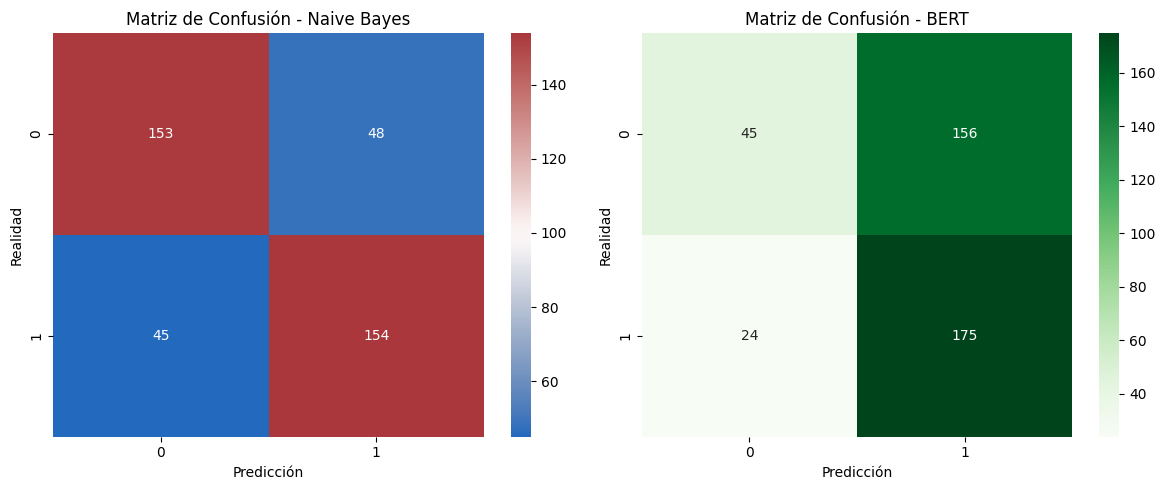

In [147]:
# Crea matrices de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_bert = confusion_matrix(y_test, y_pred_bert)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Naive Bayes
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='vlag', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Naive Bayes')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Realidad')

# BERT
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - BERT')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Realidad')

plt.tight_layout()
plt.show()

Con la matriz de confusión de Naive Bayes se puede observar que el modelo tiene un buen desempeño. La mayoría de las predicciones son correctas, aunque hay algunos falsos positivos y negativos. Esto es normal en modelos de clasificación, pero en este caso el modelo parece tener un buen desempeño general.

Con la matriz de confusión de BERT se puede observar que el modelo tiene un desempeño deficiente. Tiene un buen desempeño en los verdaderos negativos, pero los verdaderos positivos son muy bajos. De igual forma los falsos positivos son muy altos lo que indica que el modelo no clasifico correctamente la mayoría de las noticias para el *dataset* utilizado.

<a id="9.2"></a>
#### 9.2 Análisis de métricas

In [163]:
print("Classification Report Naive Bayes:\n", classification_report(y_test, y_pred_nb))
print("="*60)
print("Classification Report BERT:\n", classification_report(y_test, y_pred_bert))
print("="*60)
print("COMPARACIÓN DE MODELOS:\n")
print("Accuracy Naive Bayes: %.2f%%" % (accuracy_nb*100.0))
print("Accuracy BERT: %.2f%%" % (accuracy_bert*100.0))
print("Diferencia: %.2f%%" % ((accuracy_bert - accuracy_nb)*100.0))

Classification Report Naive Bayes:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77       201
           1       0.76      0.77      0.77       199

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400

Classification Report BERT:
               precision    recall  f1-score   support

           0       0.65      0.22      0.33       201
           1       0.53      0.88      0.66       199

    accuracy                           0.55       400
   macro avg       0.59      0.55      0.50       400
weighted avg       0.59      0.55      0.50       400

COMPARACIÓN DE MODELOS:

Accuracy Naive Bayes: 76.75%
Accuracy BERT: 55.00%
Diferencia: -21.75%


De acuerdo con el *classification report* del modelo Naive Bayes tiene un recall del $77\%$ para la clase 1 y del $76\%$ para la clase 0 (noticias falsas), lo que indica que el modelo es efectivo para identificar tanto noticias verdaderas como falsas. Además, su precisión es del $77\%$ y del $76\%$ para la clase 0 y 1 respectivamente, lo que significa que el modelo tiene un bajo número de falsos positivos y negativos.


Por otro lado, el modelo SaBERT, su recall para la clase 1 (noticias verdaderas) es alto $(88\%)$, lo que indica que el modelo es efectivo para identificar noticias verdaderas, pero su precisión es solamente del $53\%$, lo que significa que el modelo tiene un alto número de falsos positivos. Para la clase 0 (noticias falsas), el recall es muy bajo $(22\%)$, lo que implica que el modelo falla en identificar en identificar noticiasflsas, clasificando muchas de ellas como verdaderas. Esto se traduce en un alto número de falsos negativos.

<a id="10"></a>
## 10. Predicción de noticias no supervisadas con ambos modelos

Creamos una nueva función para predecir un solo texto con el modelo SaBERT:

In [127]:
# Función para predecir la clase de un texto
def predict(model, tokenizer, text, threshold=0.5):   
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
    
    predicted_class = torch.argmax(logits, dim=1).item()
    if probabilities[predicted_class] <= threshold and predicted_class == 1:
        predicted_class = 0

    return predicted_class, probabilities

In [168]:
# Prueba para verificar el mapeo del modelo
test_fake = "Descubren que beber agua del grifo convierte a las personas en superhéroes, según un estudio realizado por científicos de la Universidad de Atlantis."
test_real = "El presidente del Gobierno anunció hoy un nuevo paquete de medidas económicas para apoyar a las pequeñas y medianas empresas afectadas por la crisis, durante una rueda de prensa celebrada en el Palacio de la Moncloa."

In [170]:
# Eliminamos las stop words de los textos de prueba
test_fake = remove_stop_words(test_fake)
test_real = remove_stop_words(test_real)

pred_fake, prob_fake = predict(model, tokenizer, test_fake)
pred_real, prob_real = predict(model, tokenizer, test_real)

print(f"(SaBERT) Noticia falsa -> Predicción: {bool(pred_fake)}, Probabilidades: {prob_fake}")
print(f"(SaBERT) Noticia real -> Predicción: {bool(pred_real)}, Probabilidades: {prob_real}")

(SaBERT) Noticia falsa -> Predicción: False, Probabilidades: [0.740742564201355, 0.2592574656009674]
(SaBERT) Noticia real -> Predicción: True, Probabilidades: [0.4101056754589081, 0.5898943543434143]


Ahora probamos la misma noticia pero con el modelo Naive Bayes:

In [173]:
# Limpieza del texto de prueba
test_fake_clean = remove_stop_words(test_fake)
test_real_clean = remove_stop_words(test_real)

# Vectorización del texto limpio
test_fake_vectorized = vect.transform([test_fake_clean])
test_real_vectorized = vect.transform([test_real_clean])

# Predicción con Naive Bayes
pred_fake_nb = nb_model.predict(test_fake_vectorized)[0]
pred_real_nb = nb_model.predict(test_real_vectorized)[0]

# Mostrar resultado
print("(Naive Bayes) Noticia falsa -> Predicción:", bool(pred_fake_nb))
print("(Naive Bayes) Noticia real -> Predicción:", bool(pred_real_nb))

(Naive Bayes) Noticia falsa -> Predicción: False
(Naive Bayes) Noticia real -> Predicción: True


## Conclusión

En este proyecto se compararon tres modelos de clasificación tradicionales (Random Forest, Naive Bayes y Logistic Regression) y un modelo de *Deep Learning* (SaBERT) para la tarea de clasificación de noticias en español. El modelo Naive Bayes resultó ser el más efectivo con una exactitud del $76.76\%$, superando al modelo SaBERT, que tuvo un desempeño deficiente con una exactitud del $55\%$.

A pesar de la popularidad de los modelos de *Deep Learning*, los enfoques tradicionales demostraron ser más efectivos para esta tarea específica. Esto sugiere que, en algunos casos, los modelos más simples pueden ofrecer un rendimiento superior, especialmente cuando se dispone de un conjunto de datos limitado o cuando la tarea no requiere la complejidad de un modelo de *Deep Learning*.